# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [20]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [159]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
d.height.describe()

count    352.000000
mean     154.597093
std        7.742332
min      136.525000
25%      148.590000
50%      154.305000
75%      160.655000
max      179.070000
Name: height, dtype: float64

## Task 1. Prior predictive checks

In [6]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/lab_4/height_1_ppc.stan to exe file /home/lab_4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/lab_4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [8]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,u,sigma,height
0,0.0,0.0,176.665,15.7772,156.593
1,0.0,0.0,156.021,13.6106,159.371
2,0.0,0.0,164.590,17.2653,181.352
3,0.0,0.0,159.443,15.5989,159.099
4,0.0,0.0,165.496,14.6579,160.936




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

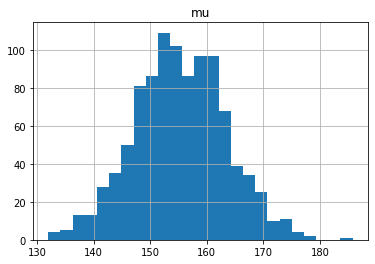

In [14]:
bins = 25
plt.hist(df.u, bins=bins)
plt.title('mu')
plt.grid()
plt.show()

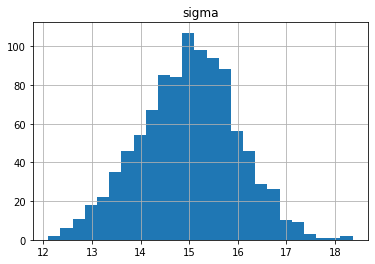

In [16]:
bins = 25
plt.hist(df.sigma, bins=bins)
plt.title('sigma')
plt.grid()
plt.show()

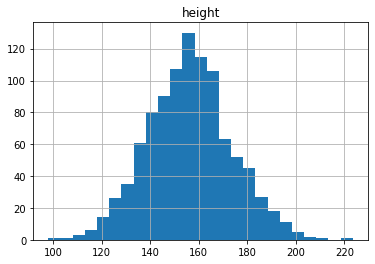

In [15]:
bins = 25
plt.hist(df.height, bins=bins)
plt.title('height')
plt.grid()
plt.show()

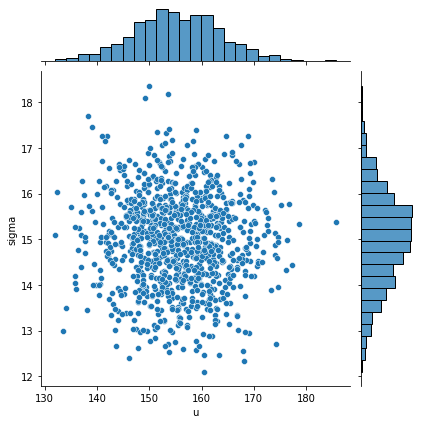

In [22]:
sns.jointplot(data=df, x='u', y='sigma')

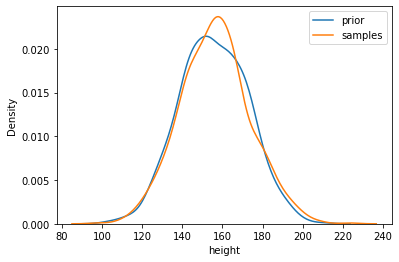

In [45]:
prior = np.random.normal(156, 17, 1000)
sns.kdeplot(x=prior, label="prior")
sns.kdeplot(data=df, x='height', label="samples")
plt.legend()
plt.show()

In [44]:
df.height.describe()

count    1000.000000
mean      156.357207
std        17.368395
min        98.084100
25%       144.343250
50%       156.361500
75%       166.862500
max       223.510000
Name: height, dtype: float64

Samples are consistent with priors and observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [47]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [48]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [49]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,u,sigma,height_pred
0,-912.888,0.935156,0.624583,1.0,3.0,0.0,914.988,154.709,8.50544,151.634
1,-913.088,0.956490,0.624583,2.0,5.0,0.0,913.527,154.852,8.29657,153.619
2,-913.919,0.854847,0.624583,2.0,3.0,0.0,914.576,155.260,8.49046,146.290
3,-912.955,0.989817,0.624583,2.0,3.0,0.0,914.106,154.724,8.30423,154.296
4,-914.091,0.942753,0.624583,3.0,7.0,0.0,914.421,154.386,8.98190,161.624



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


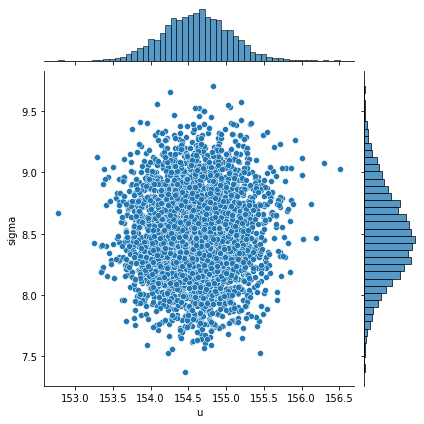

In [50]:
sns.jointplot(data=df, x='u', y='sigma')

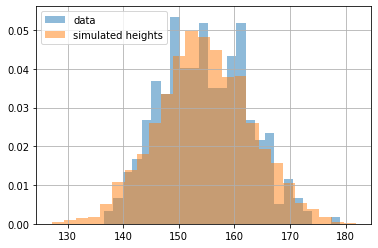

In [57]:
bins = 25
plt.hist(d.height, bins=bins, density=True, alpha=0.5, label='data')
plt.hist(df.height_pred, bins=bins, density=True, alpha=0.5, label='simulated heights')
plt.legend()
plt.grid()
plt.show()

In [58]:
df.height_pred.describe()

count    4000.000000
mean      154.641042
std         8.321447
min       127.109000
25%       149.119500
50%       154.581000
75%       160.249000
max       181.851000
Name: height_pred, dtype: float64

Mean and std of data is similar to mean and std of simulated heights.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [160]:
d['c_weight'] = d['weight'] - d['weight'].mean()

In [76]:
data_sim={'N':50, 'weight':np.linspace(d.weight.min(),d.weight.max())}


## Task 4. Prior predictive checks
 

In [110]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/lab_4/height_2a_ppc.stan to exe file /home/lab_4/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/lab_4/height_2a_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_4/height_2a_ppc.hpp /home/lab_4/height_2a_ppc.stan
Warning in '/home/lab_4/height_2a_ppc.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_2a_ppc.stan', line 12, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare 


INFO:cmdstanpy:CmdStan done processing.


In [111]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,u,alpha,sigma,beta,heights[1],heights[2],heights[3],heights[4],...,heights[41],heights[42],heights[43],heights[44],heights[45],heights[46],heights[47],heights[48],heights[49],heights[50]
0,0.0,0.0,176.665,161.217,13.7277,0.127591,146.108,168.644,181.804,196.529,...,194.3540,189.7230,172.241,149.7770,161.4460,165.186,179.4900,173.005,178.0070,152.7960
1,0.0,0.0,154.946,154.970,16.2149,0.759566,190.565,198.169,199.233,192.870,...,183.7680,196.3160,183.906,208.2070,183.4600,199.220,222.4840,200.597,195.3990,184.3540
2,0.0,0.0,145.225,166.332,14.8118,-0.160307,170.314,167.081,174.216,129.541,...,162.1530,186.0740,157.112,171.5980,163.4070,156.061,159.7090,141.895,152.5690,148.7110
3,0.0,0.0,165.632,149.722,14.7822,-0.953380,116.838,133.643,129.230,132.207,...,88.7553,87.5495,107.209,86.3139,98.7681,86.882,76.8439,115.609,79.8988,51.0802
4,0.0,0.0,150.269,148.729,14.2262,1.294470,200.676,197.484,210.337,198.491,...,216.2680,215.9680,235.150,233.3970,214.4770,216.708,202.5410,215.638,217.8370,203.2370


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

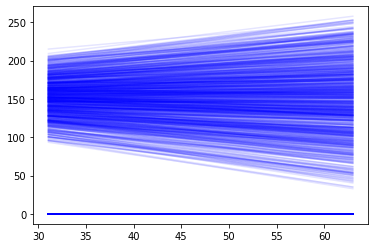

In [112]:
for i in range(1000):
    weight = np.linspace(min(d.weight), max(d.weight), 1000)
    height = weight * df.beta[i] + df.alpha[i]
    plt.plot(weight, height, 'b', alpha=0.1)
plt.show()

In [113]:
df.loc[:, 'heights[1]':'heights[50]'].values.min()

0.0

In [114]:
df.loc[:, 'heights[1]':'heights[50]'].values.max()

269.818

Possible predicted heights are consistent with minimum and maximum heights observed in nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [115]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/lab_4/height_2b_ppc.stan to exe file /home/lab_4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/lab_4/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_4/height_2b_ppc.hpp /home/lab_4/height_2b_ppc.stan
Warning in '/home/lab_4/height_2b_ppc.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_2b_ppc.stan', line 12, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare 

In [116]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [117]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,u,alpha,sigma,beta,heights[1],heights[2],heights[3],heights[4],...,heights[41],heights[42],heights[43],heights[44],heights[45],heights[46],heights[47],heights[48],heights[49],heights[50]
0,0.0,0.0,176.665,161.217,13.7277,1.136090,177.443,200.636,214.453,229.835,...,251.969,247.995,231.170,209.363,221.689,226.086,241.047,235.219,240.878,216.324
1,0.0,0.0,0.000,0.000,0.0000,0.000000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.0,0.0,145.225,166.332,14.8118,0.851882,201.764,199.191,206.985,162.969,...,219.979,244.559,216.256,231.402,223.870,217.184,221.491,204.337,215.670,212.471
3,0.0,0.0,165.632,149.722,14.7822,0.385436,158.436,176.114,172.573,176.422,...,165.241,164.908,185.439,165.416,178.743,167.729,158.563,198.200,163.362,135.416
4,0.0,0.0,0.000,0.000,0.0000,0.000000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


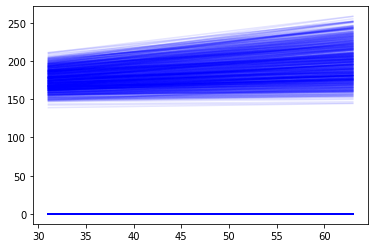

In [118]:
for i in range(1000):
    weight = np.linspace(min(d.weight), max(d.weight), 1000)
    height = weight * df.beta[i] + df.alpha[i]
    plt.plot(weight, height, 'b', alpha=0.1)
plt.show()

In [119]:
df.loc[:, 'heights[1]':'heights[50]'].values.min()

0.0

In [120]:
df.loc[:, 'heights[1]':'heights[50]'].values.max()

269.516

Possible predicted heights are consistent with minimum and maximum heights observed in nature.

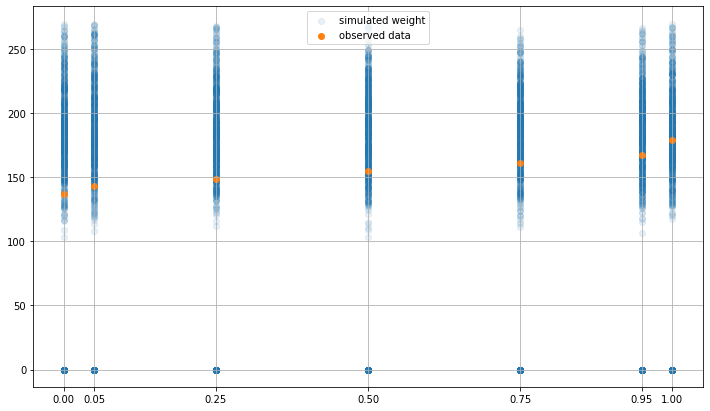

In [127]:
q = [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]

plt.figure(figsize=(12, 7))
plt.scatter(q * np.ones((1000, 1)), np.quantile(df.loc[:, 'heights[1]':'heights[50]'].values, q, axis=1), alpha=0.1, label='simulated weight')
plt.scatter(q, np.quantile(d.height, q), label='observed data')

plt.legend()
plt.grid()
plt.xticks(q)
plt.show()

## Task 6. Fitting and evaluating model


In [164]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/lab_4/height_2_fit.stan to exe file /home/lab_4/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/lab_4/height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_4/height_2_fit.hpp /home/lab_4/height_2_fit.stan
Warning in '/home/lab_4/height_2_fit.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_2_fit.stan', line 4, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_2_fit.stan', line 14, column 4: Declaration of
    arrays by placing brac

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [137]:
data_fit={'N':50, 'weights':d.weight[:50], 'heights':d.height[:50]}

In [138]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [139]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height_pred[41],height_pred[42],height_pred[43],height_pred[44],height_pred[45],height_pred[46],height_pred[47],height_pred[48],height_pred[49],height_pred[50]
0,-133.694,0.948908,0.210383,3.0,7.0,0.0,136.576,144.363,13.5339,0.184175,...,142.043,152.119,154.595,152.522,155.125,154.873,117.248,160.180,183.218,136.566
1,-133.308,0.993271,0.210383,5.0,31.0,0.0,133.863,145.629,13.1979,0.188821,...,151.957,142.949,132.581,146.455,159.441,131.304,161.210,175.768,138.235,175.093
2,-132.625,0.998731,0.210383,3.0,15.0,0.0,133.894,143.911,12.3363,0.207790,...,162.589,155.699,144.964,149.710,139.016,181.282,163.314,164.169,167.413,172.911
3,-132.120,0.975130,0.210383,4.0,15.0,0.0,133.256,137.029,11.4187,0.353007,...,145.256,151.907,163.127,149.198,137.022,147.494,150.631,163.081,166.400,148.940
4,-132.119,0.995500,0.210383,4.0,15.0,0.0,132.291,139.097,12.6586,0.340474,...,145.028,140.607,165.239,169.381,148.809,165.230,153.697,133.400,147.236,174.215


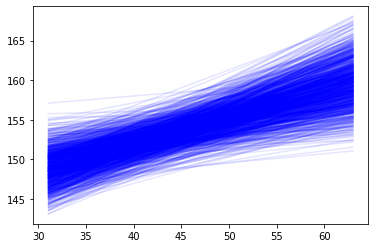

In [135]:
for i in range(1000):
    weight = np.linspace(min(d.weight), max(d.weight), 1000)
    height = weight * df.beta[i] + df.alpha[i]
    plt.plot(weight, height, 'b', alpha=0.1)
plt.show()

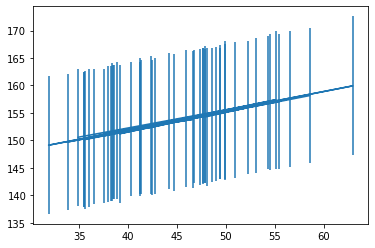

In [145]:
std = df.loc[:, 'height_pred[1]':f'height_pred[{50}]'].std()
mean = df.loc[:, 'height_pred[1]':f'height_pred[{50}]'].mean()

plt.errorbar(data_fit['weights'], mean, std)
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


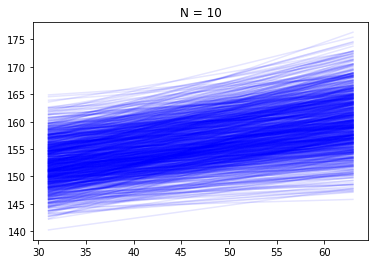

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


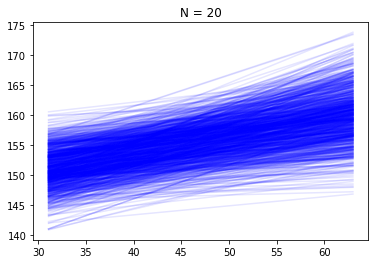

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


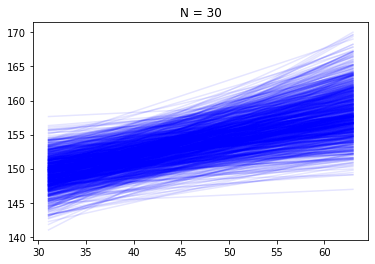

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


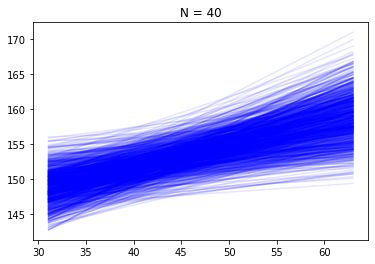

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


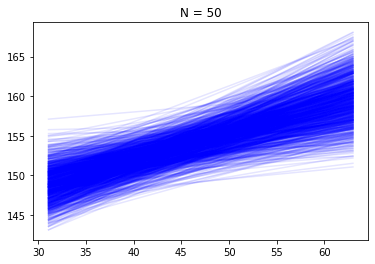

In [148]:
for i, n in enumerate([10, 20, 30, 40, 50]):
    data_fit={'N':n, 'weights':d.weight[:n], 'heights':d.height[:n]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    for i in range(1000):
        weight = np.linspace(min(d.weight), max(d.weight), 1000)
        height = weight * df.beta[i] + df.alpha[i]
        plt.plot(weight, height, 'b', alpha=0.1)
    plt.title(f'N = {n}')
    plt.show()
    
    

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


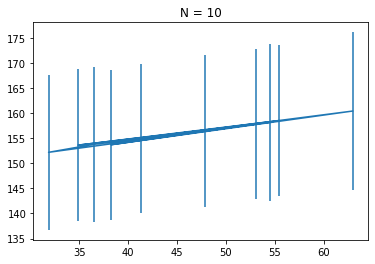

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


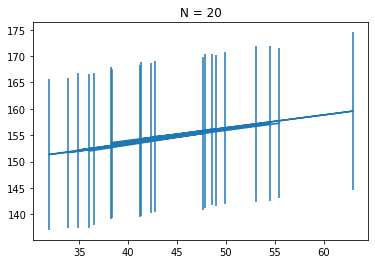

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


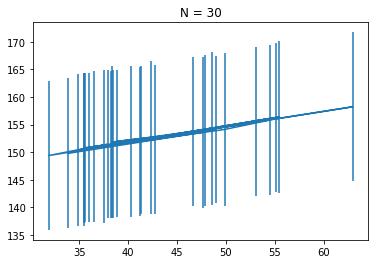

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


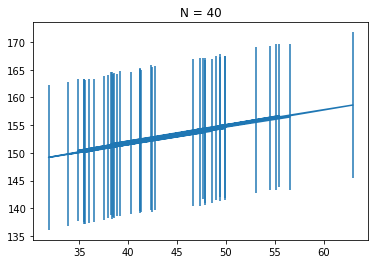

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


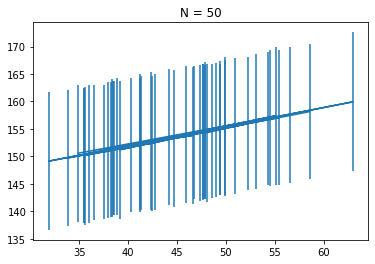

In [149]:
for i, n in enumerate([10, 20, 30, 40, 50]):
    data_fit={'N':n, 'weights':d.weight[:n], 'heights':d.height[:n]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    std = df.loc[:, 'height_pred[1]':f'height_pred[{n}]'].std()
    mean = df.loc[:, 'height_pred[1]':f'height_pred[{n}]'].mean()

    plt.errorbar(data_fit['weights'], mean, std)
    plt.title(f'N = {n}')
    plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


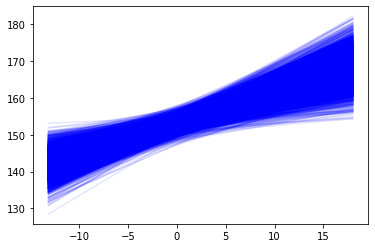

In [178]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

data_fit={'N':50, 'weights':d.c_weight[:50], 'heights':d.height[:50]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()

weight = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), 50).reshape((50, 1))
weight = np.ones((1, 4000)) * weights
height = df.beta.values * weights + df.alpha.values
plt.plot(weight, height, 'b', alpha=0.1)
plt.show()

In [187]:
model_3 = CmdStanModel(stan_file='height_3.stan')

data_fit={'N':50, 'weights':d.c_weight[:50], 'heights':d.height[:50]}
fit = model_3.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()

INFO:cmdstanpy:compiling stan file /home/lab_4/height_3.stan to exe file /home/lab_4/height_3
INFO:cmdstanpy:compiled model executable: /home/lab_4/height_3
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_4/height_3.hpp /home/lab_4/height_3.stan
Warning in '/home/lab_4/height_3.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_3.stan', line 4, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_4/height_3.stan', line 15, column 4: Declaration of
    arrays by placing brackets after a variable name is de


INFO:cmdstanpy:CmdStan done processing.


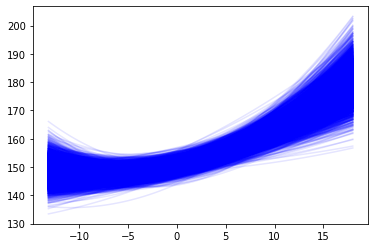

In [188]:
weight = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), 50).reshape((50, 1))
weight = np.ones((1, 4000)) * weights
height = df.beta.values * weights + df.theta.values * weights * weights + df.alpha.values
plt.plot(weight, height, 'b', alpha=0.1)
plt.show()

In [189]:
model_3_vec = CmdStanModel(stan_file='height_3.stan')

data_fit={'N':50, 'weights':d.c_weight[:50], 'heights':d.height[:50]}
fit = model_3_vec.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)






chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


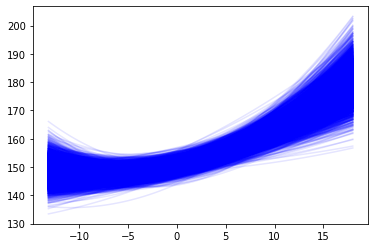

In [190]:
weight = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), 50).reshape((50, 1))
weight = np.ones((1, 4000)) * weights
height = df.beta.values * weights + df.theta.values * weights * weights + df.alpha.values
plt.plot(weight, height, 'b', alpha=0.1)
plt.show()